# Image Classification 2D

>BloodMNIST Dataset Demo: This tutorial provides a comprehensive, step-by-step guide to using the bioMONAI platform for 2D microscopy image classification tasks. 

In [ ]:
#| default_exp tutorial_classification

### Setup imports

In [ ]:
from bioMONAI.data import *
from bioMONAI.transforms import *
from bioMONAI.core import *
from bioMONAI.core import Path
from bioMONAI.data import get_image_files
from bioMONAI.losses import *
from bioMONAI.metrics import *
from bioMONAI.datasets import download_medmnist

from fastai.vision.all import CategoryBlock, GrandparentSplitter, parent_label, resnet34, CrossEntropyLossFlat, accuracy

In [ ]:
device = get_device()
print(device)

cuda


### Download dataset

> We'll employ the publicly available BloodMNIST dataset. The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes.

> bioMONAI includes a dedicated functionality for downloading MedMNIST datasets, accessible via the *download_medmnist* function.

In [ ]:
image_path = '../_data/medmnist_data/'
info = download_medmnist('bloodmnist', image_path, download_only=True)

Dataset 'bloodmnist' is already downloaded and available in '../_data/medmnist_data/bloodmnist'.


### Create Dataloader

>The next step is to define the data loading strategy for model training and validation. To this end, we'll create a DataLoader using the method *BioDataLoaders.from_source()*, configured with the arguments specified in *data_ops*.

In [ ]:
batch_size = 32

path = Path(image_path)/'bloodmnist'
path_train = path/'train'
path_val = path/'val'

data_ops = {
    'blocks':       (BioImageBlock(cls=BioImageMulti), CategoryBlock(info['label'])),
    'get_items':    get_image_files,
    'get_y':        parent_label,
    'splitter':     GrandparentSplitter(train_name='train', valid_name='val'),
    'item_tfms':    [ScaleIntensity(min=0.0, max=1.0), RandRot90(prob=0.5), RandFlip(prob=0.5)],
    'bs':           batch_size,
}

data = BioDataLoaders.from_source(
    path, 
    show_summary=False,
    **data_ops,
    )

# print length of training and validation datasets
print('train images:', len(data.train_ds.items), '\nvalidation images:', len(data.valid_ds.items))

train images: 11959 
validation images: 1712


### Data Visualization

>The *show_batch* function enables the display of input images and their corresponding targets. 

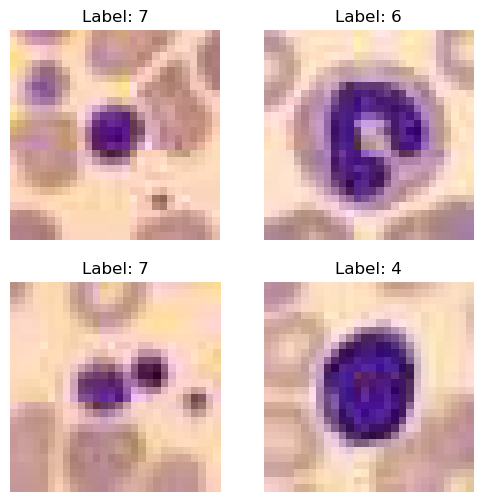

In [ ]:
data.show_batch(max_n=4)

### Load and train the model

In [ ]:
model = resnet34

loss = CrossEntropyLossFlat()
metrics = accuracy

trainer = visionTrainer(data, model, loss_fn=loss, metrics=metrics, show_summary=False)

epoch,train_loss,valid_loss,accuracy,time
0,0.708640,0.683854,0.777453,00:10
1,0.576192,0.405103,0.858061,00:10


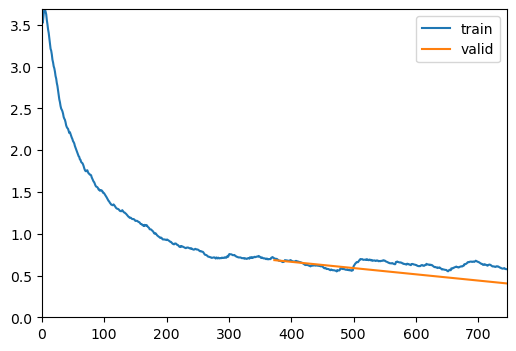

epoch,train_loss,valid_loss,accuracy,time
0,0.299481,0.193486,0.936332,00:11
1,0.293008,0.228729,0.918224,00:10
2,0.272829,0.214455,0.926402,00:09
3,0.305058,0.591883,0.805491,00:10
4,0.300107,0.269342,0.910631,00:09
5,0.284960,0.268985,0.907710,00:10
6,0.324666,0.301217,0.892523,00:10
7,0.464664,0.377951,0.877921,00:10
8,0.248325,0.231458,0.924650,00:09
9,0.221637,0.188274,0.936332,00:10


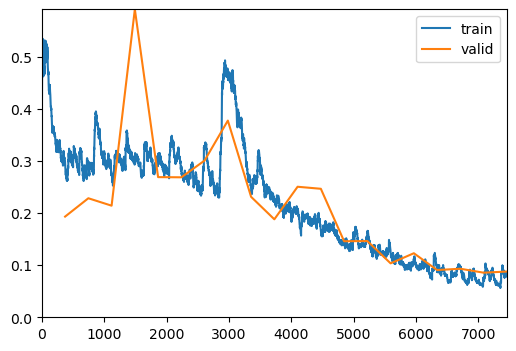

In [ ]:
trainer.fine_tune(20, freeze_epochs=2)

### Model evaluation

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       122
           1       1.00      1.00      1.00       312
           2       0.97      0.97      0.97       155
           3       0.94      0.89      0.91       290
           4       0.97      0.97      0.97       122
           5       0.91      0.96      0.93       143
           6       0.98      0.97      0.97       333
           7       1.00      1.00      1.00       235

    accuracy                           0.97      1712
   macro avg       0.96      0.97      0.96      1712
weighted avg       0.97      0.97      0.97      1712


Most Confused Classes:


[('3', '5', 12), ('6', '3', 9), ('3', '0', 8), ('3', '6', 6), ('5', '3', 6)]


,Value
CrossEntropyLossFlat,
Mean,1.313160
Median,1.274517
Standard Deviation,0.144572
Min,1.274009
Max,2.273876
Q1,1.274059
Q3,1.279382


,Value
accuracy,
Mean,0.966706
Median,1.000000
Standard Deviation,0.179404
Min,0.000000
Max,1.000000
Q1,1.000000
Q3,1.000000


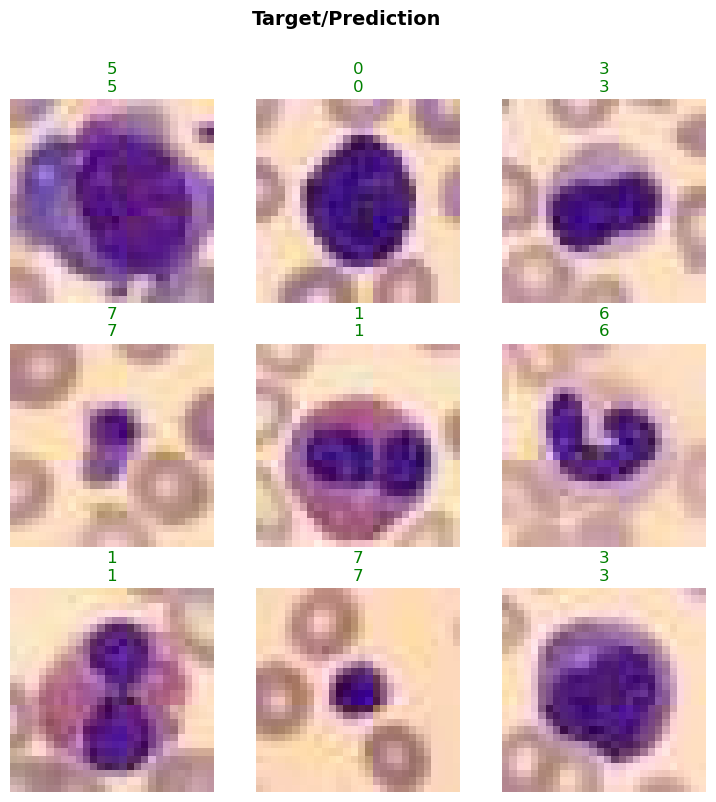

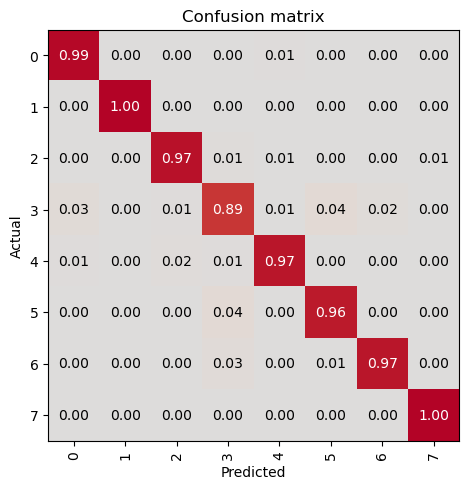

In [ ]:
evaluate_classification_model(trainer, metrics=metrics, most_confused_n=5, show_graph=False);

### Save the model

In [ ]:
# trainer.save('tmp-model')

### Test data 
Evaluate the performance of the selected model on unseen data.
It’s important to not touch this data until you have fine tuned your model to get an unbiased evaluation!

In [ ]:
path_test = path/'test'

test_data = data.test_dl(get_image_files(path_test).shuffle(), with_labels=True)
# print length of test dataset
print('test images:', len(test_data))

test images: 107


              precision    recall  f1-score   support

           0       0.96      0.94      0.95       244
           1       1.00      1.00      1.00       624
           2       0.98      0.97      0.98       311
           3       0.91      0.93      0.92       579
           4       0.95      0.95      0.95       243
           5       0.90      0.92      0.91       284
           6       0.98      0.97      0.97       666
           7       1.00      1.00      1.00       470

    accuracy                           0.96      3421
   macro avg       0.96      0.96      0.96      3421
weighted avg       0.96      0.96      0.96      3421


Most Confused Classes:


[('3', '5', 22), ('6', '3', 20), ('5', '3', 15), ('3', '6', 10), ('0', '3', 9), ('5', '4', 7), ('2', '3', 6), ('3', '0', 5), ('4', '3', 5), ('0', '5', 4), ('3', '4', 4), ('4', '5', 4), ('4', '2', 3), ('5', '0', 2), ('0', '4', 1), ('0', '6', 1), ('1', '0', 1), ('2', '1', 1), ('2', '4', 1), ('2', '6', 1), ('3', '2', 1), ('4', '0', 1), ('6', '1', 1), ('6', '2', 1)]


,Value
CrossEntropyLossFlat,
Mean,1.319366
Median,1.274616
Standard Deviation,0.156896
Min,1.274009
Max,2.274005
Q1,1.274069
Q3,1.280444


,Value
accuracy,
Mean,0.963169
Median,1.000000
Standard Deviation,0.188348
Min,0.000000
Max,1.000000
Q1,1.000000
Q3,1.000000


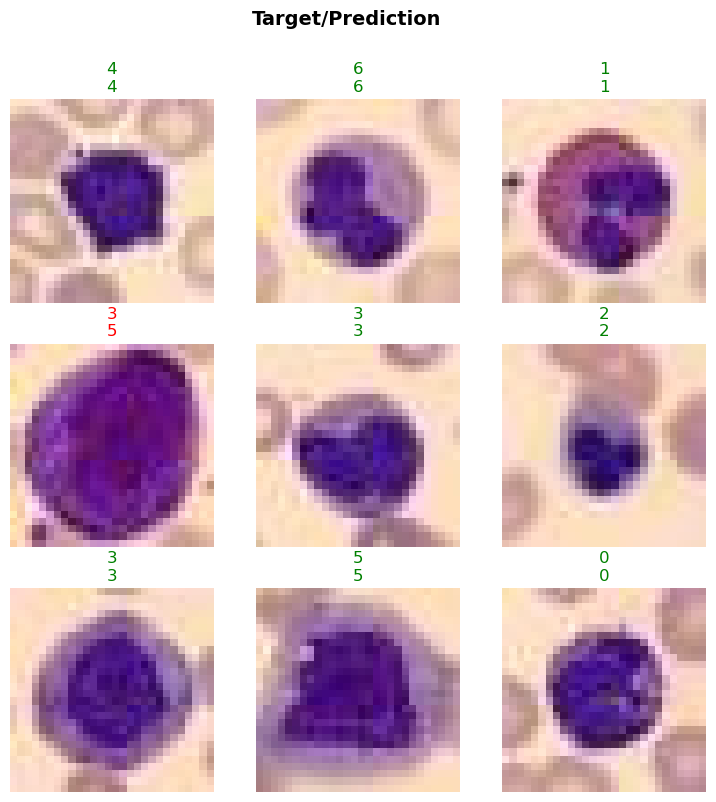

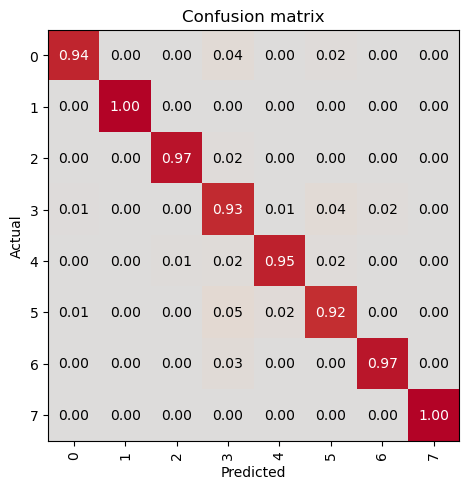

In [ ]:
evaluate_classification_model(trainer, test_data, metrics=metrics, show_graph=False);